In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
!pip install rawpy
import rawpy

In [9]:
def load_image(file_path):
    raw = rawpy.imread(file_path)
    rgb = raw.postprocess()
    return rgb


In [10]:
DIR = "data/dataset_raw/"
image_diff = load_image(f"{DIR}filter_long_exp/photo_1.CR2")
image_org = load_image(f"{DIR}long_exp/photo_1.CR2")

print(image_diff.shape)

(2856, 4290, 3)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import torch.nn.functional as F

def gaussian_kernel(sigma, k_size=3):
    """
    Generate Gaussian kernels for each pixel based on sigma values.

    Args:
        sigma (torch.Tensor): Sigma values with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Gaussian kernels with shape (B, C, H, W, k_size, k_size)
    """
    device = sigma.device
    B, C, H, W = sigma.shape
    radius = k_size // 2

    # Create kernel grid
    y, x = torch.meshgrid(
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        indexing='ij'
    )

    # Reshape for broadcasting
    x = x.view(1, 1, 1, 1, k_size, k_size)  # (1, 1, 1, 1, k, k)
    y = y.view(1, 1, 1, 1, k_size, k_size)
    sigma = sigma.unsqueeze(-1).unsqueeze(-1)  # (B, C, H, W, 1, 1)

    # Compute Gaussian weights
    coeff = 1.0 / (2 * torch.pi * sigma**2)
    exponent = -(x**2 + y**2) / (2 * sigma**2)
    weights = coeff * torch.exp(exponent)

    # Normalize kernels
    weights_sum = weights.sum(dim=(-2, -1), keepdim=True)
    weights = weights / weights_sum
    print(weights.shape)
    return weights

def adaptive_gaussian_conv2d(img, k_size=3):
    """
    Perform spatially adaptive Gaussian convolution.

    Args:
        img (torch.Tensor): Input image with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Convolved output with shape (B, C, H, W)
    """
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    B, C, H, W = img.shape
    sigma = F.relu(img) + 1e-6  # Add epsilon to avoid division by zero

    # Generate Gaussian kernels
    kernels = gaussian_kernel(sigma, k_size).to(img.device)  # (B, C, H, W, k, k)
    print(kernels.shape)

    # Unfold input image into patches
    pad = k_size // 2
    unfolded = F.unfold(img, kernel_size=k_size, padding=pad)  # (B, C*k*k, H*W)
    unfolded = unfolded.view(B, C, k_size*k_size, H, W)      # (B, C, k*k, H, W)
    unfolded = unfolded.permute(0, 1, 3, 4, 2)               # (B, C, H, W, k*k)

    # Reshape kernels and multiply with patches
    kernels_flat = kernels.view(B, C, H, W, -1)              # (B, C, H, W, k*k)
    output = (unfolded * kernels_flat).sum(dim=-1)           # (B, C, H, W)

    return output

cpu


In [14]:
blurred_image = adaptive_gaussian_conv2d(image_org, k_size=5)

torch.Size([1, 3, 2856, 4290, 5, 5])
torch.Size([1, 3, 2856, 4290, 5, 5])


255
0


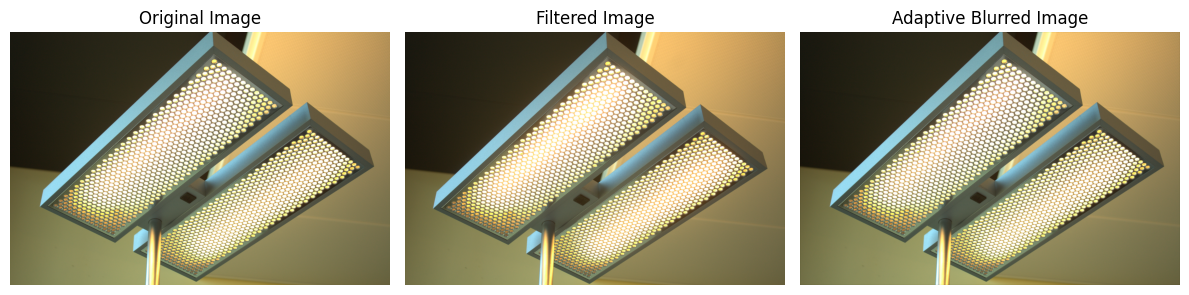

In [13]:
blurred_image = blurred_image[0].permute(1,2,0).cpu().numpy()
blurred_image = blurred_image.astype(np.uint8)

print(blurred_image.max())
print(blurred_image.min())


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_org)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(image_diff)
plt.title("Filtered Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blurred_image)
plt.title("Adaptive Blurred Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
difference = np.abs(blurred_image.astype(float) - image_diff.astype(float))

plt.figure(figsize=(12, 5))
if difference.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    # Convert to float32 or uint8 before using cv2.cvtColor
    difference = difference.astype(np.float32)  # Or use .astype(np.uint8) if values are in [0, 255]
    diff_image = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
else:
    diff_image = difference  # Already grayscale

sns.heatmap(diff_image, cmap='coolwarm', cbar=True)
plt.title("Diff Heatmap")
plt.axis("off")

AttributeError: 'Tensor' object has no attribute 'astype'